In [38]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

True
13.0
NVIDIA RTX A4000


In [39]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [40]:
import pandas as pd

df_train = pd.read_csv("sentimix_train.csv")
df_val=pd.read_csv("sentimix_val.csv")
df_test=pd.read_csv("sentimix_test.csv")


In [6]:
df_train.head()


,meta,id,tweet,sentiment,emotion
0,meta,4330,nen á vist bolest vztek smutek zmatek osam ě l...,neutral,others
1,meta,41616,@nehantics Haan yaar neha 😔😔 kab karega woh po...,neutral,sadness
2,meta,6648,@RahulGandhi television media congress ke liye...,negative,others
3,meta,2512,@AmitShah @narendramodi All India me nrc lagu ...,positive,others
4,meta,610,@Nehr _ who @TypoMantri @anjanaomkashyap Pagal...,neutral,others


In [7]:
df_train.info()
df_train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   meta       14000 non-null  object
 1   id         14000 non-null  int64 
 2   tweet      14000 non-null  object
 3   sentiment  14000 non-null  object
 4   emotion    14000 non-null  object
dtypes: int64(1), object(4)
memory usage: 547.0+ KB


meta         0
id           0
tweet        0
sentiment    0
emotion      0
dtype: int64

In [8]:
df_train['sentiment'].value_counts()

sentiment
neutral     5264
positive    4634
negative    4102
Name: count, dtype: int64

In [9]:
df_train['emotion'].value_counts()

emotion
others      6001
joy         3893
anger       2095
disgust     1048
sadness      856
fear          56
surprise      51
Name: count, dtype: int64

In [10]:
import matplotlib.pyplot as plt

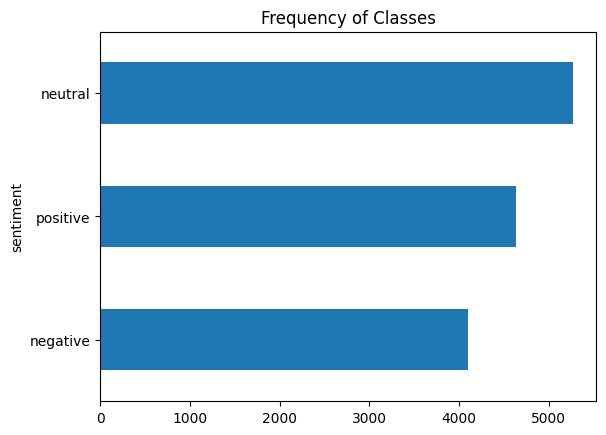

In [11]:
label_counts = df_train['sentiment'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

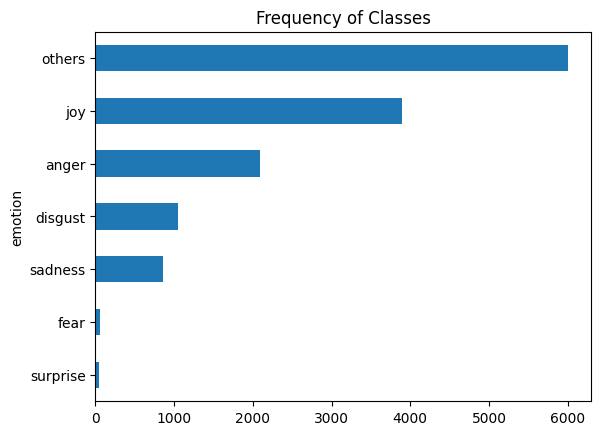

In [12]:
label_counts = df_train['emotion'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [41]:
from transformers import TrainingArguments

batch_size = 64
training_dir = "bert_base_train_dir"

training_args = TrainingArguments( output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 3,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  eval_strategy = 'epoch',
                                  disable_tqdm = False)

In [58]:
pip install -U transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [43]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoConfig, AutoModel
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, f1_score


In [44]:
# Sentiment label mapping
sentiment_unique = sorted(df_train["sentiment"].unique())
sentiment2id = {label: idx for idx, label in enumerate(sentiment_unique)}
id2sentiment = {v: k for k, v in sentiment2id.items()}

df_train["sentiment_label"] = df_train["sentiment"].map(sentiment2id)
df_val["sentiment_label"]   = df_val["sentiment"].map(sentiment2id)
df_test["sentiment_label"]  = df_test["sentiment"].map(sentiment2id)

# Emotion label mapping
emotion_unique = sorted(df_train["emotion"].unique())
emotion2id = {label: idx for idx, label in enumerate(emotion_unique)}
id2emotion = {v: k for k, v in emotion2id.items()}

df_train["emotion_label"] = df_train["emotion"].map(emotion2id)
df_val["emotion_label"]   = df_val["emotion"].map(emotion2id)
df_test["emotion_label"]  = df_test["emotion"].map(emotion2id)


In [45]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train, preserve_index=False),
    "validation": Dataset.from_pandas(df_val, preserve_index=False),
    "test": Dataset.from_pandas(df_test, preserve_index=False)
})


In [46]:
model_ckpt = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


In [47]:
def tokenize(batch):
    return tokenizer(
        batch["tweet"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

dataset = dataset.map(tokenize, batched=True)


Map: 100%|████████████████████████| 3000/3000 [00:00<00:00, 27363.79 examples/s]


In [48]:
def add_labels(batch):
    batch["labels"] = [batch["sentiment_label"], batch["emotion_label"]]
    return batch

dataset = dataset.map(add_labels)


Map: 100%|████████████████████████| 3000/3000 [00:00<00:00, 14981.53 examples/s]


In [49]:
def add_labels(batch):
    batch["labels"] = [batch["sentiment_label"], batch["emotion_label"]]
    return batch

dataset = dataset.map(add_labels)


Map: 100%|████████████████████████| 3000/3000 [00:00<00:00, 14453.25 examples/s]


In [50]:
dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)


In [51]:
"""class MultiTaskHingBERT(nn.Module):
    def __init__(self, model_ckpt, config):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_ckpt, config=config)

        hidden = self.encoder.config.hidden_size

        self.sent_head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, config.num_sentiment_labels)
        )

        self.emo_head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, config.num_emotion_labels)
        )

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0]

        sentiment_logits = self.sent_head(cls)
        emotion_logits   = self.emo_head(cls)

        loss = None
        if labels is not None:
            sentiment_labels = labels[:, 0]
            emotion_labels   = labels[:, 1]

            loss_s = self.loss_fn(sentiment_logits, sentiment_labels)
            loss_e = self.loss_fn(emotion_logits, emotion_labels)

            loss = 0.3 * loss_s + 0.3 * loss_e

        return {
            "loss": loss,
            "logits": (sentiment_logits, emotion_logits)
        }
"""

'class MultiTaskHingBERT(nn.Module):\n    def __init__(self, model_ckpt, config):\n        super().__init__()\n        self.encoder = AutoModel.from_pretrained(model_ckpt, config=config)\n\n        hidden = self.encoder.config.hidden_size\n\n        self.sent_head = nn.Sequential(\n            nn.Linear(hidden, hidden),\n            nn.ReLU(),\n            nn.Linear(hidden, config.num_sentiment_labels)\n        )\n\n        self.emo_head = nn.Sequential(\n            nn.Linear(hidden, hidden),\n            nn.ReLU(),\n            nn.Linear(hidden, config.num_emotion_labels)\n        )\n\n        self.loss_fn = nn.CrossEntropyLoss()\n\n    def forward(self, input_ids, attention_mask, labels=None):\n        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)\n        cls = outputs.last_hidden_state[:, 0]\n\n        sentiment_logits = self.sent_head(cls)\n        emotion_logits   = self.emo_head(cls)\n\n        loss = None\n        if labels is not None:\n          

In [52]:
import torch
import torch.nn as nn
from transformers import AutoModel

class MultiTaskHingBERT(nn.Module):
    def __init__(self, model_ckpt, config):
        super().__init__()

        # Shared encoder (Hing-BERT / XLM-R style, hidden_size usually 768)
        self.encoder = AutoModel.from_pretrained(model_ckpt, config=config)
        hidden = self.encoder.config.hidden_size

        # --- Task-specific dense layers (one for each task) ---
        # h1 : sentiment-specific features
        # h2 : emotion-specific features
        self.sent_dense = nn.Linear(hidden, hidden)      # for h1
        self.emo_dense  = nn.Linear(hidden, hidden)      # for h2

        # --- Output layers ---
        # Sentiment: uses h1 directly
        self.sent_out = nn.Linear(hidden, config.num_sentiment_labels)

        # Emotion: uses concatenation [h1 ⨁ h2]
        # so input dim = hidden + hidden = 2 * hidden
        self.emo_out  = nn.Linear(2 * hidden, config.num_emotion_labels)

        self.relu = nn.ReLU()
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        # Shared encoder → CLS embedding h
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0]   # [CLS] representation, called h in paper

        # --- Task-specific features ---
        # h1: sentiment features
        h1 = self.relu(self.sent_dense(cls))

        # h2: emotion features
        h2 = self.relu(self.emo_dense(cls))

        # --- Concatenation as in the paper: sentiment-aware emotion features ---
        # sentiment-aware emotion = h_concat = h1 ⨁ h2
        h_concat = torch.cat([h1, h2], dim=-1)

        # --- Logits ---
        sentiment_logits = self.sent_out(h1)        # p(s | h1) = softmax(θ1 h1)
        emotion_logits   = self.emo_out(h_concat)   # p(e | [h1 ⨁ h2])

        loss = None
        if labels is not None:
            # labels: shape (batch_size, 2) = [sentiment_label, emotion_label]
            sentiment_labels = labels[:, 0]
            emotion_labels   = labels[:, 1]

            loss_s = self.loss_fn(sentiment_logits, sentiment_labels)
            loss_e = self.loss_fn(emotion_logits, emotion_labels)

            # weights λ_sent and λ_emo; paper uses [0.3, 0.3] for TL-XLMRMTLₗₛ :contentReference[oaicite:1]{index=1}
            loss = 0.3 * loss_s + 0.3 * loss_e

        return {
            "loss": loss,
            "logits": (sentiment_logits, emotion_logits)
        }


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt)
config.num_sentiment_labels = len(sentiment2id)
config.num_emotion_labels   = len(emotion2id)
config.sentiment2id = sentiment2id
config.id2sentiment = id2sentiment
config.emotion2id   = emotion2id
config.id2emotion   = id2emotion

model = MultiTaskHingBERT(model_ckpt, config).to(device)


In [54]:
def compute_metrics(pred):
    sentiment_logits, emotion_logits = pred.predictions
    labels = pred.label_ids

    true_s = labels[:, 0]
    true_e = labels[:, 1]

    pred_s = sentiment_logits.argmax(axis=1)
    pred_e = emotion_logits.argmax(axis=1)

    return {
        "sentiment_accuracy": accuracy_score(true_s, pred_s),
        "sentiment_f1": f1_score(true_s, pred_s, average="weighted"),
        "emotion_accuracy": accuracy_score(true_e, pred_e),
        "emotion_f1": f1_score(true_e, pred_e, average="weighted")
    }


In [55]:
from transformers import TrainingArguments

batch_size = 32

training_args = TrainingArguments(
    output_dir="xlm_r_proposed_results",
    overwrite_output_dir=True,
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_strategy="epoch",
    remove_unused_columns=False  # CRITICAL FIX
)


In [56]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer
)


/tmp/ipykernel_16728/1915641784.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [57]:
trainer.train()


Epoch,Training Loss,Validation Loss,Sentiment Accuracy,Sentiment F1,Emotion Accuracy,Emotion F1
1,0.636500,0.591732,0.619667,0.617714,0.584000,0.542564
2,0.544000,0.577336,0.633667,0.631739,0.602000,0.566133
3,0.500000,0.591039,0.630000,0.629040,0.605000,0.564257
4,0.465600,0.608321,0.638333,0.635656,0.607667,0.572176
5,0.444500,0.603644,0.636333,0.633769,0.612667,0.581118


TrainOutput(global_step=2190, training_loss=0.5181241248840611, metrics={'train_runtime': 792.8411, 'train_samples_per_second': 88.29, 'train_steps_per_second': 2.762, 'total_flos': 0.0, 'train_loss': 0.5181241248840611, 'epoch': 5.0})

In [59]:
preds_output = trainer.predict(dataset["test"])
preds_output.metrics


{'test_loss': 0.49621182680130005,
 'test_sentiment_accuracy': 0.711,
 'test_sentiment_f1': 0.7113278944621116,
 'test_emotion_accuracy': 0.6573333333333333,
 'test_emotion_f1': 0.6370206737114873,
 'test_runtime': 9.0294,
 'test_samples_per_second': 332.249,
 'test_steps_per_second': 10.41}

In [60]:
import numpy as np
from sklearn.metrics import classification_report

# Extract logits from multitask model
sentiment_logits, emotion_logits = preds_output.predictions

# Predictions for each task
y_pred_sentiment = np.argmax(sentiment_logits, axis=1)
y_pred_emotion   = np.argmax(emotion_logits, axis=1)

# True label IDs
y_true = np.array(dataset["test"]["labels"])
y_true_sentiment = y_true[:, 0]
y_true_emotion   = y_true[:, 1]

# ----- SENTIMENT REPORT -----
print("=== SENTIMENT REPORT ===")
print(classification_report(
    y_true_sentiment, 
    y_pred_sentiment, 
    target_names=[id2sentiment[i] for i in sorted(id2sentiment.keys())]
))

# ----- EMOTION REPORT -----
print("=== EMOTION REPORT ===")
print(classification_report(
    y_true_emotion, 
    y_pred_emotion, 
    target_names=[id2emotion[i] for i in sorted(id2emotion.keys())]
))


=== SENTIMENT REPORT ===
              precision    recall  f1-score   support

    negative       0.73      0.73      0.73       900
     neutral       0.64      0.64      0.64      1100
    positive       0.78      0.77      0.77      1000

    accuracy                           0.71      3000
   macro avg       0.71      0.71      0.71      3000
weighted avg       0.71      0.71      0.71      3000

=== EMOTION REPORT ===
              precision    recall  f1-score   support

       anger       0.60      0.57      0.59       680
     disgust       0.00      0.00      0.00       105
        fear       0.00      0.00      0.00        13
         joy       0.87      0.74      0.80      1008
      others       0.57      0.78      0.66      1065
     sadness       0.23      0.04      0.07       122
    surprise       0.00      0.00      0.00         7

    accuracy                           0.66      3000
   macro avg       0.32      0.30      0.30      3000
weighted avg       0.64      

/home/hp/anaconda3/envs/bert-sent/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hp/anaconda3/envs/bert-sent/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hp/anaconda3/envs/bert-sent/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi